In [1]:
import pandas as pd
import altair as alt
import numpy as np
import os
import sys

source_dir = '/Users/mdeverna/Documents/Projects/mean_field_quals/src'
sys.path.insert(0, source_dir)


from simulations import run_simulation, get_peak_day, deriv_simple

### Testing with raw population counts

In [2]:
N = 1000
num_days = 100
step_size = 1  # step size
all_steps = np.arange(0, num_days, step_size)

### Set initial values ###
S_o = np.zeros(len(all_steps))
S_m = np.zeros(len(all_steps))
I_o = np.zeros(len(all_steps))
I_m = np.zeros(len(all_steps))
R_o = np.zeros(len(all_steps))
R_m = np.zeros(len(all_steps))

# These values are taking from the example found here (https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_2)
# See the image on the side...
B_o = .4
beta_mult = 2 # This doesn't do anything because we assume ord_frac = 1
B_m = B_o * beta_mult
k = 0.04

S_o[0] = 997 # The rest are in the ordinary group
I_o[0] = 3   # Three people infected


In [3]:
t = 0

all_steps = np.arange(0, num_days, step_size)

for t in range(0, len(all_steps) - 1):
    
    d_s_o, d_i_o, d_r_o, d_s_m, d_i_m, d_r_m = deriv_simple(
        beta_o = B_o,
        beta_m = B_m,
        sus_o = S_o[t],
        sus_m = S_m[t],
        inf_o = I_o[t],
        inf_m = I_m[t],
        k = k,
        counts=True,
        N=N
    )

    # Set the next value as the current plus it's change
    S_o[t + 1] = S_o[t] + d_s_o
    S_m[t + 1] = S_m[t] + d_s_m
    I_o[t + 1] = I_o[t] + d_i_o
    I_m[t + 1] = I_m[t] + d_i_m
    R_o[t + 1] = R_o[t] + d_r_o
    R_m[t + 1] = R_m[t] + d_r_m

In [4]:
import matplotlib.pyplot as plt

In [5]:
I_o[-1] + S_o[-1] + R_o[-1]

1000.0000000000005

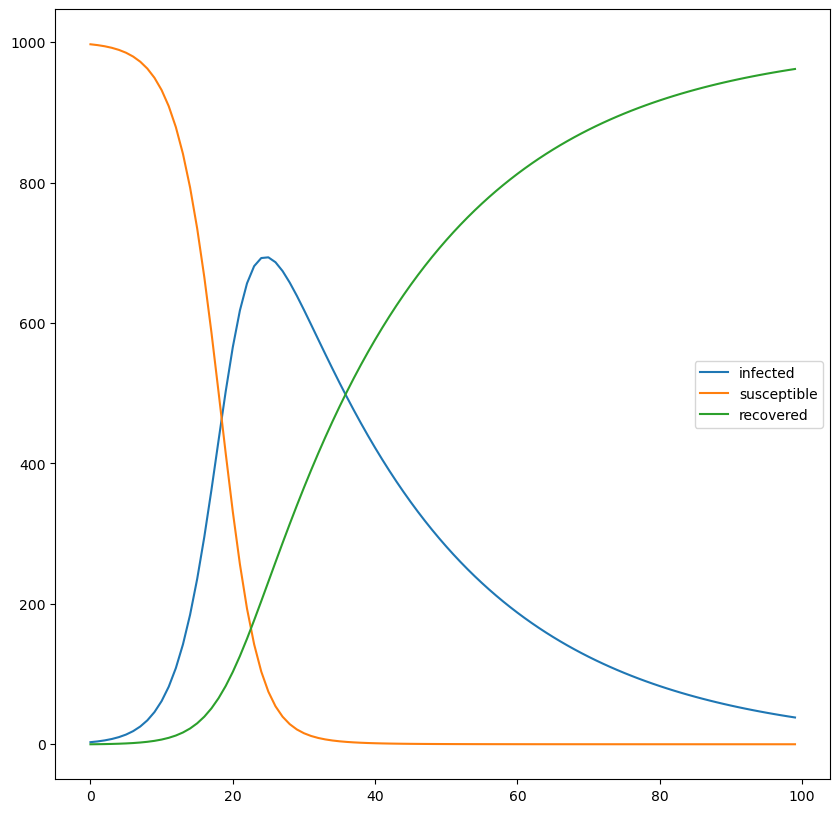

In [5]:
plt.figure(figsize=(10,10))

plt.plot(all_steps, I_o, label='infected')
plt.plot(all_steps, S_o, label='susceptible')
plt.plot(all_steps, R_o, label='recovered')

plt.legend()

# Varying $\beta$ with ordinary proportion $= x = 1$ (i.e., no misinformed).

In [225]:

# Set parameters
frac_ord = 1 # No misinformed for initial simulations
prop_infected = .001
num_days = 100
recovery_days = 5 # recovery rate gamma = .2 where recovery days = 1/.2 = 5
beta_mult = 1 # this doesn't really matter here
homophily = False # not tested here
alpha = .5 # full mixing (homophily tested later)

# Storage
r0_records = []
tot_prop_infected_records = []
daily_infection_records = []

# Simulations
beta_values = np.arange(.02, 1.02, .02)

for beta in beta_values:

    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord=frac_ord,
        prop_infec=prop_infected,
        num_days=num_days,
        beta_ord=beta,
        recovery_days=recovery_days,
        beta_mult=beta_mult,
        w_homophily=homophily,
        alpha=alpha
    )
    
    r0_records.append({
        "beta" : beta,
        "r0" : r0s[0]
    })
    tot_prop_infected_records.append({
        "beta": beta,
        "total_infected" : max(R_o)
    })
    
    for day, prop in enumerate(I_o):
        daily_infection_records.append({
            "beta":beta,
            "day":day,
            "prop_infected": prop
        })

r0_df = pd.DataFrame.from_records(r0_records)
daily_infection_df = pd.DataFrame.from_records(daily_infection_records)
tot_df = pd.DataFrame.from_records(tot_prop_infected_records)

In [231]:
daily_infection_df.head()

,beta,day,prop_infected
0,0.02,0,0.001000
1,0.02,1,0.000820
2,0.02,2,0.000672
3,0.02,3,0.000551
4,0.02,4,0.000452


In [229]:
r0_df.head()

,beta,r0
0,0.02,0.1
1,0.04,0.2
2,0.06,0.3
3,0.08,0.4
4,0.10,0.5


In [230]:
tot_df.head()

,beta,total_infected
0,0.02,0.001111
1,0.04,0.001250
2,0.06,0.001428
3,0.08,0.001665
4,0.10,0.001997


Text(-0.07, 0.95, '(c)')

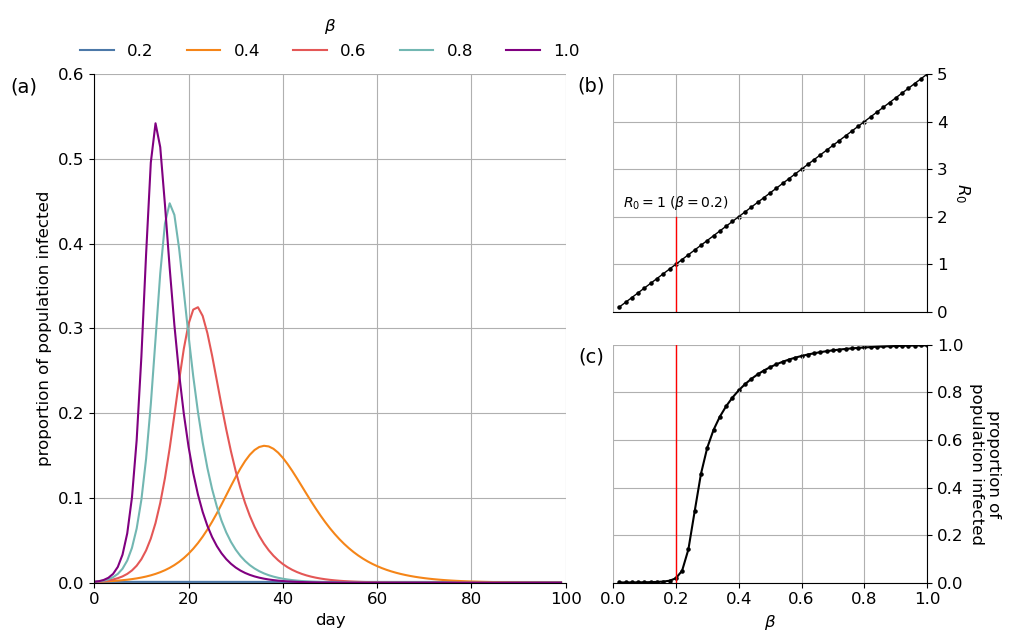

In [224]:
# Create the figure and grid layout
fig = plt.figure(figsize=(10, 6))
grid = gridspec.GridSpec(2, 2, width_ratios=[1.5, 1])

# Create subplots for the first column
ax1 = plt.subplot(grid[:, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1, 1])

# Create color map based on Tableu10 found here: https://vega.github.io/vega/docs/schemes/
color_map = {0.2: "#4c78a8", 0.4: "#f58518", 0.6: "#e45756", 0.8: "#72b7b2", 1.0: "purple"}

for beta in less_betas:
    selected_df = daily_infection_df[daily_infection_df['beta']==beta]
    
    ax1.plot(
        selected_df['day'],
        selected_df['prop_infected'],
        color = color_map[beta],
        label = beta
    )
    
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

ax1.grid()

ax1.set_xlim((0,100))
ax1.set_ylim((0,.6))

ax1.set_ylabel("proportion of population infected")
ax1.set_xlabel("day")

ax2.plot(
    r0_df['beta'],
    r0_df['r0'],
    color='black',
    linewidth=1,
)
ax2.scatter(
    r0_df['beta'],
    r0_df['r0'],
    color='black',
    s=5,
)

r0_is_one = r0_df[np.isclose(r0_df['r0'], 1)]
x = r0_is_one.beta.unique().item()
y = r0_is_one.r0.unique().item()
ax2.plot(
    [x,x],
    [0,y+1],
    color='red',
    linewidth=1
)
ax2.annotate(
    r"$R_{0} = 1$ ($\beta = 0.2$)",
    (x,y+1.1),
    va='bottom',
    ha='center',
    fontsize=10
)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)

ax2.set_xlim((0,1))
ax2.set_ylim((0,5))

ax2.grid()

ax2.xaxis.set_ticklabels([])
ax2.xaxis.set_tick_params(length=0)

ax2.set_ylabel(r"$R_{0}$", rotation=270, va='bottom')

ax3.plot(
    tot_df['beta'],
    tot_df['total_infected'],
    color='black'
)
ax3.scatter(
    tot_df['beta'],
    tot_df['total_infected'],
    color='black',
    s=5,
)

ax3.plot(
    [x,x],
    [0,1],
    color='red',
    linewidth=1
)

ax3.grid()

ax3.set_xlabel(r"$\beta$")


ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")

ax3.spines["left"].set_visible(False)
ax3.spines["top"].set_visible(False)

ax3.set_xlim((0,1))
ax3.set_ylim((0,1))


ax3.set_ylabel("proportion of\npopulation infected", rotation=270, va='bottom')


plt.tight_layout()

# Add a legend above the top left panel
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=5,
    frameon=False,
    title=r"$\beta$",
)


ax1.annotate(
    "(a)",
    xy=(-0.15, .975),
    xycoords=ax1.transAxes,
    fontsize=14,
    ha="center",
    va="center",
)
ax2.annotate(
    "(b)",
    xy=(-0.07, .95),
    xycoords=ax2.transAxes,
    fontsize=14,
    ha="center",
    va="center",
)
ax3.annotate(
    "(c)",
    xy=(-0.07, .95),
    xycoords=ax3.transAxes,
    fontsize=14,
    ha="center",
    va="center",
)

# How infections change based on recovery rate (no misinformed group)

In [258]:
# Set parameters
frac_ord = 1 # No misinformed for initial simulations
prop_infected = .001
num_days = 100
recovery_days = 5 # recovery rate gamma = .2 where recovery days = 1/.2 = 5
beta_mult = 1 # this doesn't really matter here
homophily = False # not tested here
alpha = None # full mixing (homophily tested later)

# Will store the progression of infections over time, indexed by beta values
# Storage
r0_records = []
peak_records = []
daily_infection_records = []

# We fix beta at .3 based on the above
beta= .3

# Simulate across various recovery periods
recovery_days = np.arange(1,21,1)
for rec_days in recovery_days:

    # Run the simulation based on the input 
    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord=frac_ord,
        prop_infec=prop_infected,
        num_days=num_days,
        beta_ord=beta,
        recovery_days=rec_days,
        beta_mult=beta_mult,
        w_homophily=homophily,
        alpha=None
    )
    
    r0_records.append({
        "recovery" : rec_days,
        "r0" : r0s[0]
    })
    peak_records.append({
        "recovery": rec_days,
        "peak_day" : get_peak_day(I_o)
    })
    
    for day, prop in enumerate(I_o):
        daily_infection_records.append({
            "recovery":rec_days,
            "day":day,
            "prop_infected": prop
        })
        
r0_df = pd.DataFrame.from_records(r0_records)
daily_infection_df = pd.DataFrame.from_records(daily_infection_records)
peak_day_df = pd.DataFrame.from_records(peak_records)

In [259]:
r0_df.head()

,recovery,r0
0,1,0.3
1,2,0.6
2,3,0.9
3,4,1.2
4,5,1.5


In [260]:
peak_day_df.head()

,recovery,peak_day
0,1,0
1,2,0
2,3,0
3,4,83
4,5,59


In [262]:
daily_infection_df.head()

,recovery,day,prop_infected
0,1,0,0.001000
1,1,1,0.000300
2,1,2,0.000090
3,1,3,0.000027
4,1,4,0.000008


Text(-0.07, 0.95, '(c)')

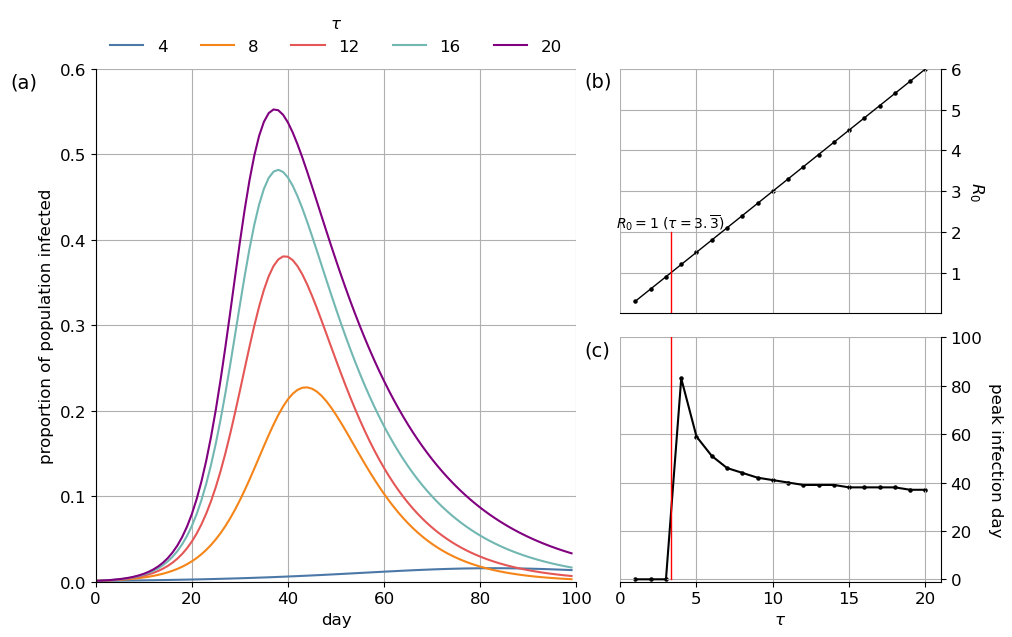

In [293]:
# Create the figure and grid layout
fig = plt.figure(figsize=(10, 6))
grid = gridspec.GridSpec(2, 2, width_ratios=[1.5, 1])

# Create subplots for the first column
ax1 = plt.subplot(grid[:, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1, 1])

# Create color map based on Tableu10 found here: https://vega.github.io/vega/docs/schemes/
color_map = {4: "#4c78a8", 8: "#f58518", 12: "#e45756", 16: "#72b7b2", 20: "purple"}

for rec_day in color_map.keys():
    selected_df = daily_infection_df[daily_infection_df['recovery']==rec_day]
    
    ax1.plot(
        selected_df['day'],
        selected_df['prop_infected'],
        color = color_map[rec_day],
        label = rec_day
    )
    
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

ax1.grid()

ax1.set_xlim((0,100))
ax1.set_ylim((0,.6))

ax1.set_ylabel("proportion of population infected")
ax1.set_xlabel("day")

ax2.yaxis.set_ticks([1,2,3,4,5,6], [1,2,3,4,5,6])

ax2.plot(
    r0_df['recovery'],
    r0_df['r0'],
    color='black',
    linewidth=1,
)
ax2.scatter(
    r0_df['recovery'],
    r0_df['r0'],
    color='black',
    s=5,
)

# # r0_is_one = r0_df[np.isclose(r0_df['r0'], 1)]
# # x = r0_is_one.beta.unique().item()
# # y = r0_is_one.r0.unique().item()
ax2.plot(
    [3.3,3.3],
    [0,2],
    color='red',
    linewidth=1
)
ax2.annotate(
    r"$R_{0} = 1$ ($\tau = 3.\overline{3}$)",
    (3.3,2),
    va='bottom',
    ha='center',
    fontsize=10
)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)

ax2.set_xlim((0,21))
ax2.set_ylim((0,6))

ax2.grid()

ax2.xaxis.set_ticklabels([])
ax2.xaxis.set_tick_params(length=0)

ax2.set_ylabel(r"$R_{0}$", rotation=270, va='bottom')

ax3.plot(
    peak_day_df['recovery'],
    peak_day_df['peak_day'],
    color='black'
)
ax3.scatter(
    peak_day_df['recovery'],
    peak_day_df['peak_day'],
    color='black',
    s=5,
)

ax3.plot(
    [3.3,3.3],
    [0,100],
    color='red',
    linewidth=1
)

ax3.grid()

ax3.set_xlabel(r"$\tau$")


ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")

ax3.spines["left"].set_visible(False)
ax3.spines["top"].set_visible(False)

ax3.set_xlim((0,21))
ax3.set_ylim((-1,100))


ax3.set_ylabel("peak infection day", rotation=270, va='bottom')


plt.tight_layout()

# Add a legend above the top left panel
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=5,
    frameon=False,
    title=r"$\tau$",
)


ax1.annotate(
    "(a)",
    xy=(-0.15, .975),
    xycoords=ax1.transAxes,
    fontsize=14,
    ha="center",
    va="center",
)
ax2.annotate(
    "(b)",
    xy=(-0.07, .95),
    xycoords=ax2.transAxes,
    fontsize=14,
    ha="center",
    va="center",
)
ax3.annotate(
    "(c)",
    xy=(-0.07, .95),
    xycoords=ax3.transAxes,
    fontsize=14,
    ha="center",
    va="center",
)

In [271]:
1/.3

3.3333333333333335

### Varying $\beta$ with half misinformed and half ordinary. Again, we fix beta at 0.3. This time we vary the multiplier effect

In [29]:
IO = .5
IM = .5

In [30]:
alpha = .5

In [31]:
(IO * alpha) + (IM * (1- alpha))

0.5

In [32]:
IO_ = (IO * alpha) + (IM * (1- alpha))
IM_ = (IO * alpha) + (IM * (1- alpha))

IO_ + IM_

1.0

In [33]:
IO_ + IM_

1.0

In [34]:
# Fraction of ordinary people
x = .5

# All beta values
beta_values = np.arange(.1, 1.1, .1)

totals = []      # Total infections
r0s_ = []        # R0 valuyes
peak_days = []   # Date of each peak

# Will store the progression of infections over time, indexed by beta values
infection_flows_ord = dict()
infection_flows_mis = dict()

recovery_days = np.arange(1,21,1)

# We fix beta at .3 and recovery at 7 days based on the above
beta = .3
rec_days = 7

# multipliers = [1.2, 1.4, 1.6, 1.8, 2, 4, 6]
multipliers = np.arange(1,4.2,.2)

for multiplier in multipliers:

    # Run the simulation based on the input 
    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord=x,
        prop_infec=.001,
        num_days=100,
        beta_ord=beta,
        recovery_days=rec_days,
        beta_mult=multiplier,
        w_homophily=False,
        alpha=None
    )
    total_ord_inf = max(R_o)
    total_mis_inf = max(R_m)

    infection_flows_ord[np.round(multiplier,1)] = I_o
    infection_flows_mis[np.round(multiplier,1)] = I_m
    
    # ord_r0, mis_r0, weighted_avg_r0
    r0s_.append( (r0s[0], r0s[1], r0s[2], multiplier) )

    totals.append((total_ord_inf, total_mis_inf, multiplier))

### Clean

In [35]:
# Fraction of ordinary people
x = .5
num_days = 100

totals = []      # Total infections
r0s_ = []        # R0 valuyes
peak_days = []   # Date of each peak

# Will store the progression of infections over time, indexed by beta values
infection_flows_ord = dict()
infection_flows_mis = dict()

recovery_days = np.arange(1,21,1)

# We fix beta at .3 and recovery at 7 days based on the above
beta = .3
rec_days = 7

# multipliers = [1.2, 1.4, 1.6, 1.8, 2, 4, 6]
multipliers = np.arange(1,4.2,.2)

for multiplier in multipliers:

    # Run the simulation based on the input 
    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord=x,
        prop_infec=.001,
        num_days=num_days,
        beta_ord=beta,
        recovery_days=rec_days,
        beta_mult=multiplier,
        w_homophily=False,
        alpha=None,
        mixed=False
    )
    total_ord_inf = max(R_o)
    total_mis_inf = max(R_m)

    infection_flows_ord[np.round(multiplier,1)] = I_o
    infection_flows_mis[np.round(multiplier,1)] = I_m
    
    # ord_r0, mis_r0, weighted_avg_r0
    r0s_.append( (r0s[0], r0s[1], r0s[2], multiplier) )

    totals.append({
        'total_ord_inf' : total_ord_inf,
        'total_mis_inf' : total_mis_inf,
        'multiplier' : multiplier,
        'diff' : total_mis_inf - total_ord_inf,
        'total_inf' : total_ord_inf + total_mis_inf
    })

In [36]:
both_totals = pd.DataFrame.from_records(totals)
both_totals

,total_ord_inf,total_mis_inf,multiplier,diff,total_inf
0,0.413049,0.413223,1.0,0.000174,0.826272
1,0.421837,0.446702,1.2,0.024865,0.868539
2,0.426648,0.466947,1.4,0.040298,0.893595
3,0.429522,0.479434,1.6,0.049912,0.908957
4,0.431337,0.487216,1.8,0.055879,0.918553
5,0.432530,0.492085,2.0,0.059555,0.924615
6,0.433340,0.495132,2.2,0.061792,0.928471
7,0.433907,0.497031,2.4,0.063124,0.930938
8,0.434316,0.498209,2.6,0.063893,0.932525
9,0.434621,0.498932,2.8,0.064311,0.933553


In [37]:
r0frames = pd.DataFrame(r0s_, columns = ['ordinary', 'misinfo', 'weighted_avg', 'multiplier'])

r0frames

,ordinary,misinfo,weighted_avg,multiplier
0,2.1,2.10,2.10,1.0
1,2.1,2.52,2.31,1.2
2,2.1,2.94,2.52,1.4
3,2.1,3.36,2.73,1.6
4,2.1,3.78,2.94,1.8
5,2.1,4.20,3.15,2.0
6,2.1,4.62,3.36,2.2
7,2.1,5.04,3.57,2.4
8,2.1,5.46,3.78,2.6
9,2.1,5.88,3.99,2.8


In [38]:
combined_infections = pd.DataFrame(infection_flows_ord) + pd.DataFrame(infection_flows_mis)
combined_infections = combined_infections.reset_index()
combined_infections = combined_infections.rename(columns={'index':'day'})
combined_infections.day = combined_infections.day + 1
combined_infections = combined_infections.melt(id_vars='day')
combined_infections.rename(columns={"variable":"lambda"},inplace=True)
combined_infections['group'] = "combined"

In [39]:
combined_infections

,day,lambda,value,group
0,1,1.0,0.001000,combined
1,2,1.0,0.001157,combined
2,3,1.0,0.001338,combined
3,4,1.0,0.001548,combined
4,5,1.0,0.001790,combined
...,...,...,...,...
1595,96,4.0,0.000023,combined
1596,97,4.0,0.000020,combined
1597,98,4.0,0.000018,combined
1598,99,4.0,0.000016,combined


In [40]:
infections_ord = pd.DataFrame(infection_flows_ord).reset_index()
infections_ord = infections_ord.rename(columns={'index':'day'})
infections_ord.day = infections_ord.day + 1
infections_ord = infections_ord.melt(id_vars='day')
infections_ord

,day,variable,value
0,1,1.0,0.000000
1,2,1.0,0.000150
2,3,1.0,0.000302
3,4,1.0,0.000459
4,5,1.0,0.000626
...,...,...,...
1595,96,4.0,0.000021
1596,97,4.0,0.000019
1597,98,4.0,0.000017
1598,99,4.0,0.000015


In [41]:
infections_mis = pd.DataFrame(infection_flows_mis).reset_index()
infections_mis = infections_mis.rename(columns={'index':'day'})
infections_mis.day = infections_mis.day + 1
infections_mis = infections_mis.melt(id_vars='day')

In [42]:
infections_mis.rename(columns={"variable":"lambda"},inplace=True)
infections_ord.rename(columns={"variable":"lambda"},inplace=True)

infections_mis['group'] = 'misinformed'
infections_ord['group'] = 'ordinary'

In [43]:
both_infections = pd.concat((infections_mis,infections_ord, combined_infections))

In [44]:
both_infections

,day,lambda,value,group
0,1,1.0,0.001000,misinformed
1,2,1.0,0.001007,misinformed
2,3,1.0,0.001036,misinformed
3,4,1.0,0.001088,misinformed
4,5,1.0,0.001164,misinformed
...,...,...,...,...
1595,96,4.0,0.000023,combined
1596,97,4.0,0.000020,combined
1597,98,4.0,0.000018,combined
1598,99,4.0,0.000016,combined


In [45]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [46]:
combined_infections[combined_infections['multiplier'] == 2]['value'].max() \
/ combined_infections[combined_infections['multiplier'] == 1]['value'].max()

KeyError: 'multiplier'

In [47]:
combined_infections['multiplier'].unique()

KeyError: 'multiplier'

In [48]:
combined_infections

,day,lambda,value,group
0,1,1.0,0.001000,combined
1,2,1.0,0.001157,combined
2,3,1.0,0.001338,combined
3,4,1.0,0.001548,combined
4,5,1.0,0.001790,combined
...,...,...,...,...
1595,96,4.0,0.000023,combined
1596,97,4.0,0.000020,combined
1597,98,4.0,0.000018,combined
1598,99,4.0,0.000016,combined


In [49]:
print(get_peak_day(infection_flows_ord[4]))
print(get_peak_day(infection_flows_mis[4]))

19
16


### Not used currently...

In [48]:
no_diff_peak_day = get_peak_day(infection_flows_ord[1])
max_diff_peak_day = get_peak_day(infection_flows_mis[4])
no_diff_y = max(infection_flows_ord[1]) + max(infection_flows_mis[1] + .02)
max_diff_y = max(infection_flows_ord[4]) + max(infection_flows_mis[4])

comb_text_df = pd.DataFrame({
    'x' : [no_diff_peak_day, max_diff_peak_day],
    'y' : [no_diff_y, max_diff_y],
    'text' : ["no subpopulation difference", "large subpopulation difference"]
})

### Calculate the total extra proportion of the population infected

In [50]:
both_totals['total_extra'] = (both_totals['total_inf'] - both_totals['total_inf'].min()) #/ both_totals['total_inf'].min()

In [51]:
both_totals

,total_ord_inf,total_mis_inf,multiplier,diff,total_inf,total_extra
0,0.413049,0.413223,1.0,0.000174,0.826272,0.000000
1,0.421837,0.446702,1.2,0.024865,0.868539,0.042267
2,0.426648,0.466947,1.4,0.040298,0.893595,0.067323
3,0.429522,0.479434,1.6,0.049912,0.908957,0.082684
4,0.431337,0.487216,1.8,0.055879,0.918553,0.092281
5,0.432530,0.492085,2.0,0.059555,0.924615,0.098343
6,0.433340,0.495132,2.2,0.061792,0.928471,0.102199
7,0.433907,0.497031,2.4,0.063124,0.930938,0.104666
8,0.434316,0.498209,2.6,0.063893,0.932525,0.106252
9,0.434621,0.498932,2.8,0.064311,0.933553,0.107281


In [52]:
infections_mis

,day,lambda,value,group
0,1,1.0,1.000000e-03,misinformed
1,2,1.0,1.006843e-03,misinformed
2,3,1.0,1.036136e-03,misinformed
3,4,1.0,1.088312e-03,misinformed
4,5,1.0,1.164303e-03,misinformed
...,...,...,...,...
1595,96,4.0,1.792355e-06,misinformed
1596,97,4.0,1.537238e-06,misinformed
1597,98,4.0,1.318451e-06,misinformed
1598,99,4.0,1.130818e-06,misinformed


In [53]:
totals

[{'total_ord_inf': 0.41304925004506515,
  'total_mis_inf': 0.41322315130932485,
  'multiplier': 1.0,
  'diff': 0.00017390126425970154,
  'total_inf': 0.8262724013543901},
 {'total_ord_inf': 0.42183718237411,
  'total_mis_inf': 0.44670199433762137,
  'multiplier': 1.2,
  'diff': 0.02486481196351137,
  'total_inf': 0.8685391767117314},
 {'total_ord_inf': 0.4266484776672601,
  'total_mis_inf': 0.46694685113127676,
  'multiplier': 1.4,
  'diff': 0.04029837346401666,
  'total_inf': 0.8935953287985369},
 {'total_ord_inf': 0.42952244654175153,
  'total_mis_inf': 0.47943444793049755,
  'multiplier': 1.5999999999999999,
  'diff': 0.04991200138874602,
  'total_inf': 0.908956894472249},
 {'total_ord_inf': 0.43133728272512756,
  'total_mis_inf': 0.4872158480967377,
  'multiplier': 1.7999999999999998,
  'diff': 0.05587856537161012,
  'total_inf': 0.9185531308218653},
 {'total_ord_inf': 0.4325299409400005,
  'total_mis_inf': 0.4920849799597346,
  'multiplier': 1.9999999999999998,
  'diff': 0.0595550

In [54]:
np.round(np.geomspace(1,6,10),2)

array([1.  , 1.22, 1.49, 1.82, 2.22, 2.71, 3.3 , 4.03, 4.92, 6.  ])

In [55]:
.3 * 4

1.2

In [56]:
both_totals['total_extra'].max()

0.10921973012687158

# For pub

In [57]:
combined_infections

,day,lambda,value,group
0,1,1.0,0.001000,combined
1,2,1.0,0.001157,combined
2,3,1.0,0.001338,combined
3,4,1.0,0.001548,combined
4,5,1.0,0.001790,combined
...,...,...,...,...
1595,96,4.0,0.000023,combined
1596,97,4.0,0.000020,combined
1597,98,4.0,0.000018,combined
1598,99,4.0,0.000016,combined


In [59]:
less_combined = combined_infections[combined_infections.multiplier.isin([1,2,3,4])].copy()
less_mis = infections_mis[infections_mis.multiplier.isin([1,2,3,4])].copy()
less_ord = infections_ord[infections_ord.multiplier.isin([1,2,3,4])].copy()

AttributeError: 'DataFrame' object has no attribute 'multiplier'

In [60]:
both_infections

,day,lambda,value,group
0,1,1.0,0.001000,misinformed
1,2,1.0,0.001007,misinformed
2,3,1.0,0.001036,misinformed
3,4,1.0,0.001088,misinformed
4,5,1.0,0.001164,misinformed
...,...,...,...,...
1595,96,4.0,0.000023,combined
1596,97,4.0,0.000020,combined
1597,98,4.0,0.000018,combined
1598,99,4.0,0.000016,combined


In [61]:
less_combined = both_infections[
    (both_infections.group == "combined") \
    & (both_infections['lambda'].isin([1,2,3,4]))
].copy()
less_mis = both_infections[
    (both_infections.group == "misinformed") \
    & (both_infections['lambda'].isin([1,2,3,4]))
].copy()
less_ord = both_infections[
    (both_infections.group == "combined") \
    & (both_infections['lambda'].isin([1,2,3,4]))
].copy()

In [62]:
both_infections['lambda'].unique()

array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4,
       3.6, 3.8, 4.0], dtype=object)

In [63]:
less_ord

,day,lambda,value,group
0,1,1.0,0.001000,combined
1,2,1.0,0.001157,combined
2,3,1.0,0.001338,combined
3,4,1.0,0.001548,combined
4,5,1.0,0.001790,combined
...,...,...,...,...
1595,96,4.0,0.000023,combined
1596,97,4.0,0.000020,combined
1597,98,4.0,0.000018,combined
1598,99,4.0,0.000016,combined


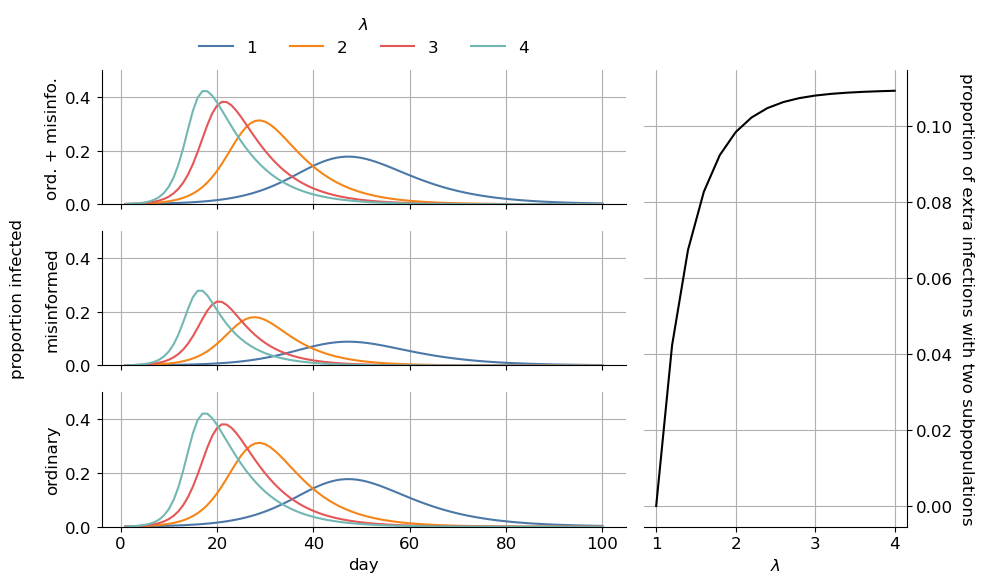

In [64]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set the font size for all text
plt.rcParams.update({'font.size': 12})

# Create color map based on Tableu10 found here: https://vega.github.io/vega/docs/schemes/
color_map = {
    1:"#4c78a8",
    2:"#f58518",
    3:"#e45756",
    4:"#72b7b2"
}

# Create the figure and grid layout
fig = plt.figure(figsize=(10, 6))
grid = gridspec.GridSpec(3, 2, width_ratios=[2, 1])

# Create subplots for the first column
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[1, 0])
ax3 = plt.subplot(grid[2, 0])

## Combined figure
for mult in less_combined['lambda'].unique():
    temp_df = less_combined[less_combined['lambda'] == mult]
    ax1.plot(
        temp_df['day'],
        temp_df['value'],
        color = color_map[mult],
        label = int(mult)
    )

## Misinformed figure
for mult in less_mis['lambda'].unique():
    temp_df = less_mis[less_mis['lambda'] == mult]
    ax2.plot(
        temp_df['day'],
        temp_df['value'],
        color = color_map[mult],
        label = int(mult)
    )
    
## Ordinary figure
for mult in less_ord['lambda'].unique():
    temp_df = less_ord[less_ord['lambda'] == mult]
    ax3.plot(
        temp_df['day'],
        temp_df['value'],
        color = color_map[mult],
        label = int(mult)
    )


# Set the y-axis limits for the first column
ax1.set_ylim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax3.set_ylim(0, 0.5)

# Share y-axis limits for the first column
ax2.sharey(ax1)
ax3.sharey(ax1)

# Add gridlines to all subplots
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

# Remove spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Remove x-axis ticks
ax1.xaxis.set_ticklabels([])
ax2.xaxis.set_ticklabels([])

### Create right panel

# Create subplot for the second column spanning all three rows
ax4 = plt.subplot(grid[:, 1])

# Plot extra infections
ax4.plot(
    both_totals['multiplier'],
    both_totals['total_extra'],
    color = "black",
)
# ax4.scatter(
#     both_totals['lambda'],
#     both_totals['total_extra'],
#     marker='x',
#     color='black'
# )

# Move the y-axis of the right spanning plot to the right side
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')

# # Set the y-axis limits for the second column
# ax4.set_ylim(0, 1)

# Add gridlines to the subplot in the second column
ax4.grid(True)

# Remove spines
ax4.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Set labels for each subplot
ax1.set_ylabel('ord. + misinfo.')
ax2.set_ylabel('proportion infected\n\nmisinformed')
ax3.set_ylabel('ordinary')
ax3.set_xlabel('day')
ax4.set_ylabel('proportion of extra infections with two subpopulations', rotation=-90, va='bottom')
ax4.set_xlabel('$\lambda$')


# Add a legend above the top left panel
ax1.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    ncol=4,
    frameon=False,
    title = '$\lambda$',
)


# Adjust the spacing between subplots
# plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()

# Save the plot
plt.savefig('../figures/mf_lambda_effect.pdf', dpi = 800)
